<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S9/blob/main/S9_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

#import from local modules
from cifar10_dataset import Cifar10Dataset
from train import train, test, checkpoint, resume
from utils import get_device, plot_accuracy_losses, plot_top_loss
from model_5 import Net

# Check if GPU available

In [2]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [3]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [4]:
# train data shape
print(train_data_raw.data.shape)
# train data mean
print(train_data_raw.data.mean(axis=(0,1,2))/255)
# train data standard deviation
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


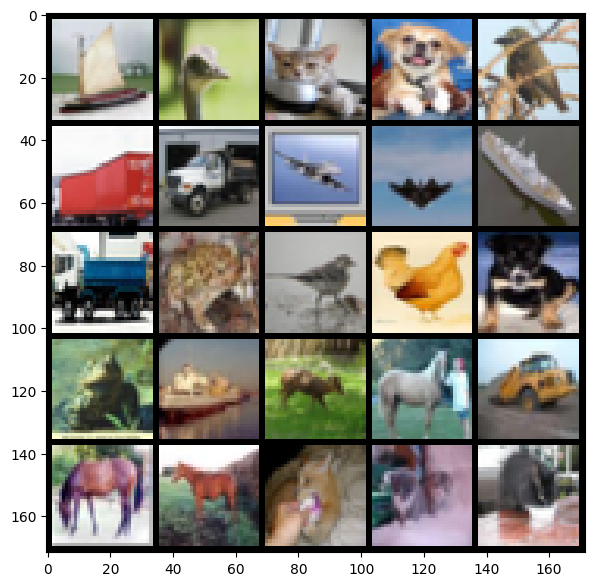

In [6]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [7]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


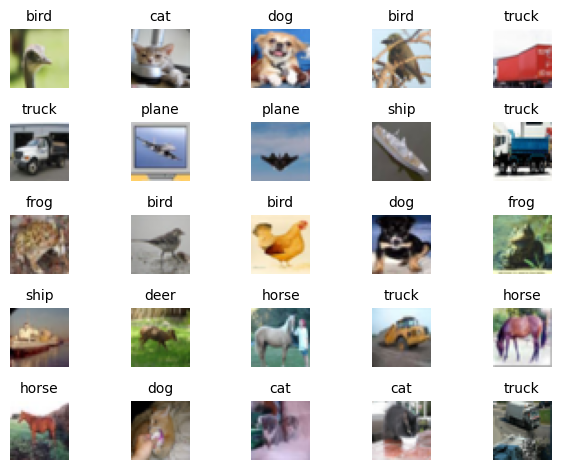

In [8]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [9]:
# Train Phase transformations
train_transforms = A.Compose([
                                # A.Compose([
                                #     A.PadIfNeeded (min_height=36, min_width=36, p = 1.0),
                                #     A.RandomCrop(p=1, height=32, width=32),
                                # ], p = 0.5),
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(p=0.5),
                                # A.ColorJitter(p = 0.5),
                                A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                                # A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                #                 fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=0.5),
                                A.Compose([A.PadIfNeeded (min_height=64, min_width=64, p = 1.0),
                                            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                                fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=1),
                                           A.CenterCrop(height=32, width=32, p=1),
                                ], p = 1),
                                ToTensorV2(),
                                ])

# Test Phase transformations
test_transforms = A.Compose([
                            A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                            ToTensorV2(),
                            ])

# Dataset and Creating Train/Test Split

In [10]:
train_data = Cifar10Dataset(transform=train_transforms)
test_data = Cifar10Dataset(train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_data

Dataset Cifar10Dataset
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose([
             HorizontalFlip(always_apply=False, p=0.5),
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.262), max_pixel_value=255.0),
             Compose([
               PadIfNeeded(always_apply=False, p=1.0, min_height=64, min_width=64, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
               CoarseDropout(always_apply=False, p=1, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914, 0.4822, 0.4465], m

# Dataloader Arguments & Test/Train Dataloaders

In [12]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

### Augmented data visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


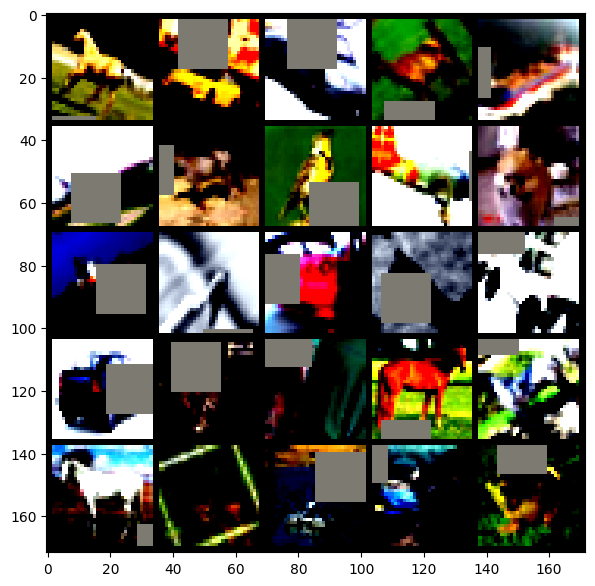

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

# Training

In [15]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
             ReLU-14           [-1, 64,

strided - 641,248 - 51% - 74%  
Dilated - 641,248 - 47% - 68%

197,152
with random resized crop
61% - 75% (56 e) - 53% - 69% (20e)

wo
dilated - 65% - 74% (20 e)  
        76% - 81% (72 e)

In [16]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [17]:
current_learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=current_learning_rate,
                      momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 3,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 100
early_stopping_patience = 10
best_test_loss = np.inf
best_epoch = -1

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    if current_learning_rate != scheduler.get_last_lr()[0]:
        current_learning_rate = scheduler.get_last_lr()[0]
        print(f'Learning rate updated to: {current_learning_rate}')
        best_epoch = epoch
        # break

    # early stopping
    if tst_loss < best_test_loss:
        best_test_loss = tst_loss
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif epoch - best_epoch > early_stopping_patience:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop

resume(model, "best_model.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=2.0123 Batch_id=390 Accuracy=30.77: 100%|██████████| 391/391 [00:24<00:00, 15.96it/s]


Test set: Average loss: 1.6998, Accuracy: 3736/10000 (37.36%)

Epoch 2


Train: Loss=1.7658 Batch_id=390 Accuracy=40.38: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s]


Test set: Average loss: 1.4371, Accuracy: 4768/10000 (47.68%)

Epoch 3


Train: Loss=1.4755 Batch_id=390 Accuracy=44.97: 100%|██████████| 391/391 [00:17<00:00, 22.21it/s]


Test set: Average loss: 1.3333, Accuracy: 5187/10000 (51.87%)

Epoch 4


Train: Loss=1.4600 Batch_id=390 Accuracy=48.92: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]


Test set: Average loss: 1.2413, Accuracy: 5595/10000 (55.95%)

Epoch 5


Train: Loss=1.4118 Batch_id=390 Accuracy=51.26: 100%|██████████| 391/391 [00:17<00:00, 22.24it/s]


Test set: Average loss: 1.1742, Accuracy: 5891/10000 (58.91%)

Epoch 6


Train: Loss=1.3612 Batch_id=390 Accuracy=53.60: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]


Test set: Average loss: 1.1284, Accuracy: 6032/10000 (60.32%)

Epoch 7


Train: Loss=1.2420 Batch_id=390 Accuracy=55.55: 100%|██████████| 391/391 [00:19<00:00, 20.17it/s]


Test set: Average loss: 1.1331, Accuracy: 6041/10000 (60.41%)

Epoch 8


Train: Loss=1.2558 Batch_id=390 Accuracy=57.04: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]


Test set: Average loss: 1.0534, Accuracy: 6323/10000 (63.23%)

Epoch 9


Train: Loss=1.3197 Batch_id=390 Accuracy=57.97: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]


Test set: Average loss: 1.0167, Accuracy: 6506/10000 (65.06%)

Epoch 10


Train: Loss=1.1027 Batch_id=390 Accuracy=59.13: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]


Test set: Average loss: 0.9720, Accuracy: 6601/10000 (66.01%)

Epoch 11


Train: Loss=0.9988 Batch_id=390 Accuracy=60.12: 100%|██████████| 391/391 [00:18<00:00, 21.28it/s]


Test set: Average loss: 0.9790, Accuracy: 6615/10000 (66.15%)

Epoch 12


Train: Loss=0.9816 Batch_id=390 Accuracy=60.69: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]


Test set: Average loss: 0.9555, Accuracy: 6699/10000 (66.99%)

Epoch 13


Train: Loss=1.2511 Batch_id=390 Accuracy=61.38: 100%|██████████| 391/391 [00:18<00:00, 21.39it/s]


Test set: Average loss: 0.9275, Accuracy: 6803/10000 (68.03%)

Epoch 14


Train: Loss=1.1798 Batch_id=390 Accuracy=62.18: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]


Test set: Average loss: 0.9315, Accuracy: 6820/10000 (68.20%)

Epoch 15


Train: Loss=0.9980 Batch_id=390 Accuracy=62.87: 100%|██████████| 391/391 [00:18<00:00, 21.47it/s]


Test set: Average loss: 0.8981, Accuracy: 6972/10000 (69.72%)

Epoch 16


Train: Loss=1.1430 Batch_id=390 Accuracy=63.24: 100%|██████████| 391/391 [00:17<00:00, 22.30it/s]


Test set: Average loss: 0.8898, Accuracy: 6986/10000 (69.86%)

Epoch 17


Train: Loss=1.1385 Batch_id=390 Accuracy=63.61: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s]


Test set: Average loss: 0.8518, Accuracy: 7067/10000 (70.67%)

Epoch 18


Train: Loss=1.1565 Batch_id=390 Accuracy=64.57: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]


Test set: Average loss: 0.8346, Accuracy: 7141/10000 (71.41%)

Epoch 19


Train: Loss=1.0468 Batch_id=390 Accuracy=64.52: 100%|██████████| 391/391 [00:18<00:00, 21.19it/s]


Test set: Average loss: 0.8371, Accuracy: 7184/10000 (71.84%)

Epoch 20


Train: Loss=0.8944 Batch_id=390 Accuracy=65.14: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]


Test set: Average loss: 0.8234, Accuracy: 7196/10000 (71.96%)

Epoch 21


Train: Loss=0.9897 Batch_id=390 Accuracy=65.19: 100%|██████████| 391/391 [00:18<00:00, 20.76it/s]


Test set: Average loss: 0.8855, Accuracy: 6917/10000 (69.17%)

Epoch 22


Train: Loss=1.1941 Batch_id=390 Accuracy=65.56: 100%|██████████| 391/391 [00:17<00:00, 22.21it/s]


Test set: Average loss: 0.7950, Accuracy: 7288/10000 (72.88%)

Epoch 23


Train: Loss=1.0417 Batch_id=390 Accuracy=65.64: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s]


Test set: Average loss: 0.8019, Accuracy: 7224/10000 (72.24%)

Epoch 24


Train: Loss=0.8926 Batch_id=390 Accuracy=66.47: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]


Test set: Average loss: 0.7640, Accuracy: 7408/10000 (74.08%)

Epoch 25


Train: Loss=0.8199 Batch_id=390 Accuracy=66.88: 100%|██████████| 391/391 [00:18<00:00, 21.30it/s]


Test set: Average loss: 0.7714, Accuracy: 7417/10000 (74.17%)

Epoch 26


Train: Loss=0.9961 Batch_id=390 Accuracy=67.02: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]


Test set: Average loss: 0.7847, Accuracy: 7336/10000 (73.36%)

Epoch 27


Train: Loss=0.8565 Batch_id=390 Accuracy=67.48: 100%|██████████| 391/391 [00:19<00:00, 19.82it/s]


Test set: Average loss: 0.7567, Accuracy: 7412/10000 (74.12%)

Epoch 28


Train: Loss=0.9926 Batch_id=390 Accuracy=67.52: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]


Test set: Average loss: 0.7880, Accuracy: 7328/10000 (73.28%)

Epoch 29


Train: Loss=0.9489 Batch_id=390 Accuracy=67.53: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]


Test set: Average loss: 0.7567, Accuracy: 7455/10000 (74.55%)

Epoch 30


Train: Loss=0.9182 Batch_id=390 Accuracy=68.04: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]


Test set: Average loss: 0.7679, Accuracy: 7410/10000 (74.10%)

Epoch 31


Train: Loss=0.8870 Batch_id=390 Accuracy=67.94: 100%|██████████| 391/391 [00:18<00:00, 21.46it/s]


Test set: Average loss: 0.7457, Accuracy: 7448/10000 (74.48%)

Epoch 32


Train: Loss=0.7276 Batch_id=390 Accuracy=68.57: 100%|██████████| 391/391 [00:17<00:00, 22.05it/s]


Test set: Average loss: 0.7547, Accuracy: 7468/10000 (74.68%)

Epoch 33


Train: Loss=0.7289 Batch_id=390 Accuracy=68.60: 100%|██████████| 391/391 [00:17<00:00, 21.82it/s]


Test set: Average loss: 0.7457, Accuracy: 7487/10000 (74.87%)

Epoch 34


Train: Loss=0.7667 Batch_id=390 Accuracy=69.05: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]


Test set: Average loss: 0.7492, Accuracy: 7458/10000 (74.58%)

Epoch 35


Train: Loss=1.0209 Batch_id=390 Accuracy=68.92: 100%|██████████| 391/391 [00:18<00:00, 21.23it/s]


Test set: Average loss: 0.7375, Accuracy: 7483/10000 (74.83%)

Epoch 36


Train: Loss=0.7590 Batch_id=390 Accuracy=69.39: 100%|██████████| 391/391 [00:17<00:00, 21.80it/s]


Test set: Average loss: 0.7241, Accuracy: 7548/10000 (75.48%)

Epoch 37


Train: Loss=1.2508 Batch_id=390 Accuracy=69.34: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]


Test set: Average loss: 0.7535, Accuracy: 7444/10000 (74.44%)

Epoch 38


Train: Loss=0.7875 Batch_id=390 Accuracy=69.72: 100%|██████████| 391/391 [00:17<00:00, 22.11it/s]


Test set: Average loss: 0.7049, Accuracy: 7595/10000 (75.95%)

Epoch 39


Train: Loss=0.7792 Batch_id=390 Accuracy=69.53: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]


Test set: Average loss: 0.7083, Accuracy: 7588/10000 (75.88%)

Epoch 40


Train: Loss=0.6620 Batch_id=390 Accuracy=69.99: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]


Test set: Average loss: 0.7027, Accuracy: 7620/10000 (76.20%)

Epoch 41


Train: Loss=0.8219 Batch_id=390 Accuracy=70.18: 100%|██████████| 391/391 [00:18<00:00, 21.45it/s]


Test set: Average loss: 0.7255, Accuracy: 7568/10000 (75.68%)

Epoch 42


Train: Loss=0.9827 Batch_id=390 Accuracy=70.08: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]


Test set: Average loss: 0.6884, Accuracy: 7688/10000 (76.88%)

Epoch 43


Train: Loss=0.8352 Batch_id=390 Accuracy=70.66: 100%|██████████| 391/391 [00:18<00:00, 21.56it/s]


Test set: Average loss: 0.6831, Accuracy: 7620/10000 (76.20%)

Epoch 44


Train: Loss=0.7962 Batch_id=390 Accuracy=70.43: 100%|██████████| 391/391 [00:17<00:00, 22.09it/s]


Test set: Average loss: 0.6801, Accuracy: 7694/10000 (76.94%)

Epoch 45


Train: Loss=1.0111 Batch_id=390 Accuracy=70.99: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]


Test set: Average loss: 0.6837, Accuracy: 7650/10000 (76.50%)

Epoch 46


Train: Loss=0.8661 Batch_id=390 Accuracy=71.04: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]


Test set: Average loss: 0.6866, Accuracy: 7647/10000 (76.47%)

Epoch 47


Train: Loss=0.9978 Batch_id=390 Accuracy=70.90: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s]


Test set: Average loss: 0.7017, Accuracy: 7632/10000 (76.32%)

Epoch 48


Train: Loss=0.7553 Batch_id=390 Accuracy=70.62: 100%|██████████| 391/391 [00:18<00:00, 21.30it/s]


Test set: Average loss: 0.6902, Accuracy: 7685/10000 (76.85%)

Learning rate updated to: 0.010000000000000002
Epoch 49


Train: Loss=0.7280 Batch_id=390 Accuracy=72.99: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]


Test set: Average loss: 0.6335, Accuracy: 7874/10000 (78.74%)

Epoch 50


Train: Loss=0.6257 Batch_id=390 Accuracy=73.54: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]


Test set: Average loss: 0.6211, Accuracy: 7885/10000 (78.85%)

Epoch 51


Train: Loss=0.8638 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:17<00:00, 21.78it/s]


Test set: Average loss: 0.6158, Accuracy: 7908/10000 (79.08%)

Epoch 52


Train: Loss=0.8082 Batch_id=390 Accuracy=73.92: 100%|██████████| 391/391 [00:18<00:00, 21.49it/s]


Test set: Average loss: 0.6134, Accuracy: 7928/10000 (79.28%)

Epoch 53


Train: Loss=0.7798 Batch_id=390 Accuracy=74.09: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]


Test set: Average loss: 0.6153, Accuracy: 7925/10000 (79.25%)

Epoch 54


Train: Loss=0.5422 Batch_id=390 Accuracy=74.27: 100%|██████████| 391/391 [00:17<00:00, 21.91it/s]


Test set: Average loss: 0.6116, Accuracy: 7935/10000 (79.35%)

Epoch 55


Train: Loss=0.4890 Batch_id=390 Accuracy=74.06: 100%|██████████| 391/391 [00:17<00:00, 21.83it/s]


Test set: Average loss: 0.6119, Accuracy: 7933/10000 (79.33%)

Epoch 56


Train: Loss=0.7845 Batch_id=390 Accuracy=74.05: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]


Test set: Average loss: 0.6060, Accuracy: 7929/10000 (79.29%)

Epoch 57


Train: Loss=0.5507 Batch_id=390 Accuracy=74.08: 100%|██████████| 391/391 [00:19<00:00, 20.11it/s]


Test set: Average loss: 0.6075, Accuracy: 7919/10000 (79.19%)

Epoch 58


Train: Loss=0.7496 Batch_id=390 Accuracy=74.27: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]


Test set: Average loss: 0.6081, Accuracy: 7940/10000 (79.40%)

Epoch 59


Train: Loss=0.6682 Batch_id=390 Accuracy=74.31: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s]


Test set: Average loss: 0.6096, Accuracy: 7908/10000 (79.08%)

Epoch 60


Train: Loss=0.9286 Batch_id=390 Accuracy=74.27: 100%|██████████| 391/391 [00:18<00:00, 21.54it/s]


Test set: Average loss: 0.6109, Accuracy: 7925/10000 (79.25%)

Learning rate updated to: 0.0010000000000000002
Epoch 61


Train: Loss=0.7238 Batch_id=390 Accuracy=74.59: 100%|██████████| 391/391 [00:18<00:00, 21.26it/s]


Test set: Average loss: 0.6052, Accuracy: 7922/10000 (79.22%)

Epoch 62


Train: Loss=0.6701 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]


Test set: Average loss: 0.6067, Accuracy: 7930/10000 (79.30%)

Epoch 63


Train: Loss=0.7206 Batch_id=390 Accuracy=74.81: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s]


Test set: Average loss: 0.6055, Accuracy: 7936/10000 (79.36%)

Epoch 64


Train: Loss=0.7364 Batch_id=390 Accuracy=74.50: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]


Test set: Average loss: 0.6082, Accuracy: 7922/10000 (79.22%)

Epoch 65


Train: Loss=0.7267 Batch_id=390 Accuracy=74.42: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s]


Test set: Average loss: 0.6072, Accuracy: 7937/10000 (79.37%)

Learning rate updated to: 0.00010000000000000003
Epoch 66


Train: Loss=0.6466 Batch_id=390 Accuracy=74.80: 100%|██████████| 391/391 [00:18<00:00, 21.19it/s]


Test set: Average loss: 0.6030, Accuracy: 7936/10000 (79.36%)

Epoch 67


Train: Loss=0.5694 Batch_id=390 Accuracy=74.66: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]


Test set: Average loss: 0.6087, Accuracy: 7930/10000 (79.30%)

Epoch 68


Train: Loss=0.9203 Batch_id=390 Accuracy=74.76: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]


Test set: Average loss: 0.6046, Accuracy: 7938/10000 (79.38%)

Epoch 69


Train: Loss=0.6117 Batch_id=390 Accuracy=74.83: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]


Test set: Average loss: 0.6073, Accuracy: 7922/10000 (79.22%)

Epoch 70


Train: Loss=0.7147 Batch_id=390 Accuracy=74.88: 100%|██████████| 391/391 [00:17<00:00, 21.77it/s]


Test set: Average loss: 0.6072, Accuracy: 7919/10000 (79.19%)

Epoch 71


Train: Loss=0.7156 Batch_id=390 Accuracy=75.16: 100%|██████████| 391/391 [00:18<00:00, 20.67it/s]


Test set: Average loss: 0.6005, Accuracy: 7962/10000 (79.62%)

Epoch 72


Train: Loss=0.8706 Batch_id=390 Accuracy=74.70: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]


Test set: Average loss: 0.6067, Accuracy: 7925/10000 (79.25%)

Epoch 73


Train: Loss=0.7097 Batch_id=390 Accuracy=74.58: 100%|██████████| 391/391 [00:18<00:00, 20.65it/s]


Test set: Average loss: 0.6094, Accuracy: 7924/10000 (79.24%)

Epoch 74


Train: Loss=0.7808 Batch_id=390 Accuracy=74.71: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]


Test set: Average loss: 0.6064, Accuracy: 7938/10000 (79.38%)

Epoch 75


Train: Loss=0.6484 Batch_id=390 Accuracy=74.47: 100%|██████████| 391/391 [00:19<00:00, 20.40it/s]


Test set: Average loss: 0.6038, Accuracy: 7933/10000 (79.33%)

Epoch 76


Train: Loss=0.6571 Batch_id=390 Accuracy=74.80: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]


Test set: Average loss: 0.6033, Accuracy: 7930/10000 (79.30%)

Epoch 77


Train: Loss=0.7624 Batch_id=390 Accuracy=74.91: 100%|██████████| 391/391 [00:18<00:00, 20.72it/s]


Test set: Average loss: 0.6058, Accuracy: 7924/10000 (79.24%)

Epoch 78


Train: Loss=0.7620 Batch_id=390 Accuracy=74.58: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]


Test set: Average loss: 0.6061, Accuracy: 7929/10000 (79.29%)

Epoch 79


Train: Loss=0.7877 Batch_id=390 Accuracy=74.86: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]


Test set: Average loss: 0.6040, Accuracy: 7942/10000 (79.42%)

Epoch 80


Train: Loss=0.6572 Batch_id=390 Accuracy=74.83: 100%|██████████| 391/391 [00:17<00:00, 21.92it/s]


Test set: Average loss: 0.6054, Accuracy: 7943/10000 (79.43%)

Epoch 81


Train: Loss=0.8040 Batch_id=390 Accuracy=74.78: 100%|██████████| 391/391 [00:18<00:00, 20.61it/s]


Test set: Average loss: 0.6064, Accuracy: 7923/10000 (79.23%)

Epoch 82


Train: Loss=0.7455 Batch_id=390 Accuracy=74.97: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]


Test set: Average loss: 0.6017, Accuracy: 7948/10000 (79.48%)

Early stopped training at epoch 82


In [18]:
# final learning rate
scheduler.get_last_lr()

[0.00010000000000000003]

## Visualise training and test losses and accuracies

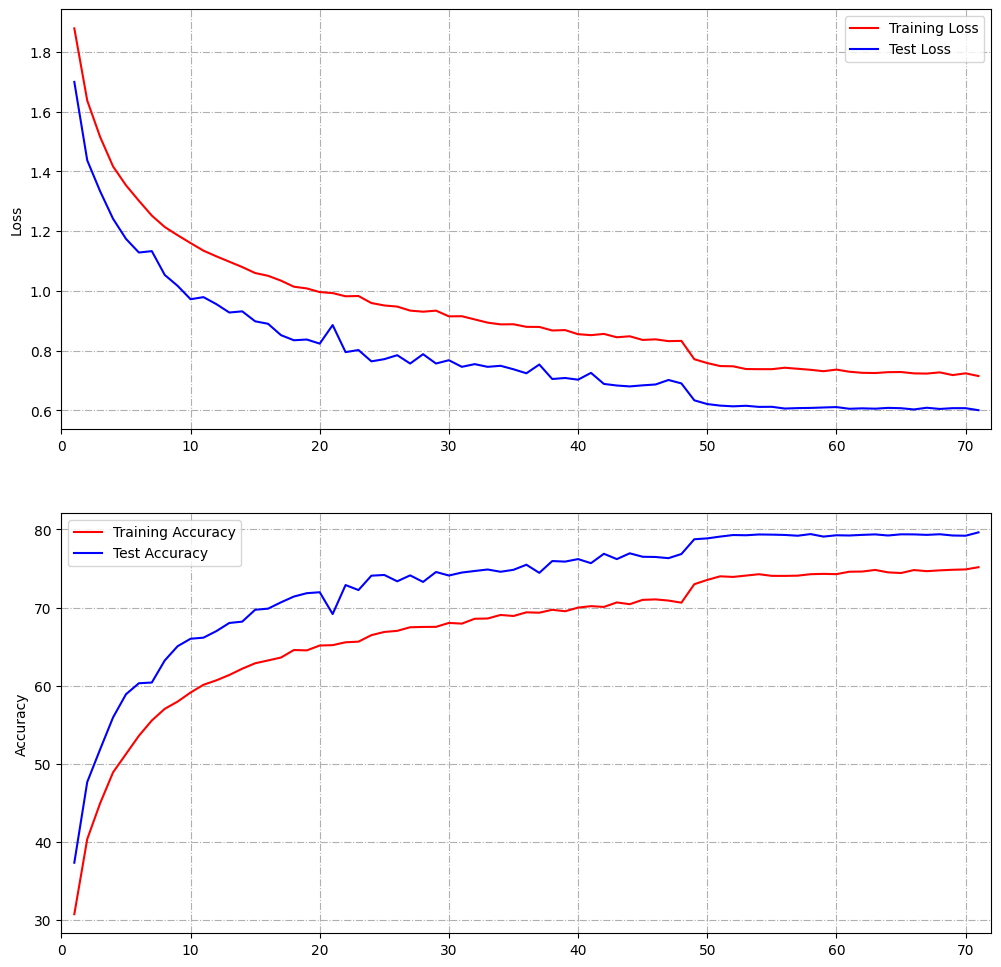

In [19]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, best_epoch)

## Error analysis

total wrong predictions: 2038


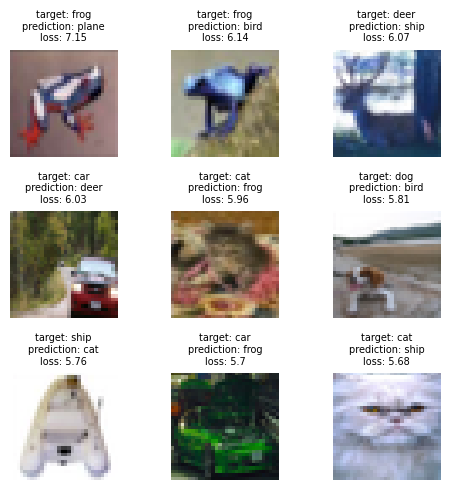

In [20]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=3, img_cols = 3)

In [21]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
38,dog,cat,1.506998,181
21,cat,dog,1.459553,88
2,bird,deer,2.053977,85
17,car,truck,1.570422,83
22,cat,frog,2.031184,75
...,...,...,...,...
35,deer,truck,2.841659,2
85,truck,frog,2.915388,2
28,deer,car,3.065604,2
46,frog,car,4.556896,2
